In the ordinary least squares setting, we model our outputs $\mathbf{y}=X\boldsymbol\beta+\boldsymbol\varepsilon$ where $\boldsymbol\varepsilon\sim N(\mathbf{0}, \sigma^2 I)$, with $\boldsymbol\beta,\sigma^2$ unknown.

As a result the OLS fit $\hat{\boldsymbol\beta}\sim N\left((X^\top X)^{-1}X^\top \mathbf{y},\sigma^2 (X^\top X)^{-1}\right)$ (an distribution with an unknown variance scaling factor which we must still Studentize) is sensitive to the stability of the inverse of the Gram $X^\top X$.

One interesting question is whether to scale and center inputs. For a provided design matrix $X$, we could consider centering it, by subtracting the mean of each column, i.e, $(I-\frac{1}{n}J)X=X(I-\mathbf{1}\overline{\mathbf{x}}^\top)$, using numpy-like broadcasting on the left and $J=\mathbf{1}\mathbf{1}^\top$ on the right, or scaling each column by a diagonal matrix $N$ of $X$ column norms or $S$ of column standard deviations by a right-multiplication $XN$ or $XS$. We'll assume we're fitting a generalized linear model with an intercept.

In this document, we'll keep the intercept terms $\beta_0$ separate from coefficient terms.

There are several questions to ask:

* How does standardization affect statistical inferences?
* How does standardization affect numerical stability?

"How can we use standardization to aid interpretation?" is an interesting question [people disagree on](https://statmodeling.stat.columbia.edu/2009/07/11/when_to_standar/). I won't discuss it here (my view is that there's some "natural" parameterization that the experimenter selects, so that's what should be used). Note that this is usually the most important question when deciding on standardization. *The goal of this notebook is to explore the computational effects of standardization, which are the parts that you usually don't need to worry about if calling a software package.*

After, we review other remedies for degeneracy.

# Standardization and Inference

By rewriting the least squares objective, it's clear that any least squares solution $\tilde {\boldsymbol\beta}$ for centered covariates is isomorphic to the the uncentered solution $\hat{ \boldsymbol\beta}$, except the intercept, which will change as $\tilde{\beta}_0=\hat{\beta}_0-\overline{\mathbf{x}}^\top \hat{\beta}$. This includes the optimal solution, so centering won't change our coefficients. Using $\tilde X = (I-\frac{1}{n}J)X$:

$$
\left\|\mathbf{y}-X\hat{\boldsymbol\beta}-\hat\beta_0\mathbf{1}\right\|^2=\left\|\mathbf{y}-\left(\tilde{X} + \frac{1}{n}JX\right)\hat{\boldsymbol\beta}-\tilde\beta_0\mathbf{1}\right\|^2=\left\|\mathbf{y}-\tilde{X}\hat{\boldsymbol\beta}-\mathbf{1}\left(\hat\beta_0+\overline{\mathbf{x}}^\top\hat{\boldsymbol\beta}\right)\right\|^2
$$

What's less obvious is why the p-values stay the same (for the coefficients, predictably, for a non-centered intercept its standard error increases since it's an extrapolation). Intuitively, the transformed standard errors are proportional to $\mathrm{diag}\left(\begin{pmatrix}\mathbf{1}&\tilde X\end{pmatrix}^\top \begin{pmatrix}\mathbf 1&\tilde X\end{pmatrix}\right)^{-1}$, and the first step in any matrix Gram-Schmidt-like (i.e., QR) inversion routine would be to project out the first column). Mathematically, the invariance (on all but the first row and first column of the covariance matrix) is seen by idempotence that $(I-\frac{1}{n}J)^2=(I-\frac{1}{n}J)$, orthogonality $(I-\frac{1}{n}J)\mathbf{1}=\mathbf{0}$, and the fact that $\tilde X = (I-\frac{1}{n}J)X$.

A similar isomorphism holds for $XS$, with corresponding solution isomorphism $S^{-1}\boldsymbol\beta$. Here, the standard errors are shifted by a factor of $S$, but so are the coefficients, so p-values stay the same.

In [1]:
import numpy as np
%matplotlib inline
import scipy.linalg as sla
np.random.seed(1234)

def invdiag(X):
    n, p = X.shape
    assert p <= n
    Q, R, P = sla.qr(X, pivoting=True, mode='economic')
    # P is a permutation, so right mul selects columns
    # and left mul selects rows, but the indices are
    # returned are column indices, so indexing is flipped.
    # X P = Q R [p is a permutation matrix, thus unitary]
    # X' X == P (X P)' (X P) P'
    #      == P R' R P'
    # (X'X)^{-1} == P R^{-1} (R')^{-1} P' I
    
    Pinv = np.empty_like(P)
    Pinv[P] = np.arange(len(P), dtype=P.dtype)
    
    XTXinv = sla.solve_triangular(
        R,
        sla.solve_triangular(
            R,
            np.eye(p)[P],
            trans='T'
        ),
    )[Pinv]
    
    return np.diag(XTXinv)

X = np.random.normal(size=(100, 10))
print(np.linalg.norm(invdiag(X) - np.diag(sla.pinvh(X.T.dot(X)))))

def add1(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

4.648282108864984e-17


In [2]:
sigma = 5 # make the p-values spicy
n = 100
p = 10
beta0 = 1

centers = np.random.normal(size=p)
scales = np.random.gamma(sigma, size=p)

settings = [
    ('shift', centers, np.ones_like(scales)),
    ('scale', np.zeros_like(centers), scales),
    ('shift+scale', centers, scales),
]

for name, shift, scale in settings:
    print(name)

    beta = np.random.normal(size=p)
    eps = np.random.normal(size=n) * sigma
    X = np.random.normal(size=(n, p)) * scale + shift
    y = beta0 + X.dot(beta) + eps

    XX = add1(X)
    beta_hat, rss_hat, rank, _ = np.linalg.lstsq(XX, y, rcond=None)
    assert rank == p + 1, rank
    var_hat = invdiag(XX) * rss_hat

    XX = add1(X * scale - shift)
    beta_tilde, rss_tilde, rank, _ = np.linalg.lstsq(XX, y, rcond=None)
    assert rank == p + 1, rank
    var_tilde = invdiag(XX) * rss_hat

    print('rss diff', abs(rss_hat.item() - rss_tilde.item()))
    print('se diff', np.linalg.norm(np.sqrt(var_hat[1:]) - scale * np.sqrt(var_tilde[1:])))
    print('coef diff', np.linalg.norm(beta_hat[1:] / scale - beta_tilde[1:]))
    print('intercept diff', beta_tilde[0] - beta_hat[0], 'coef sum', shift.dot(beta_hat[1:] / scale))
    rss_hat, rss_tilde

shift
rss diff 4.547473508864641e-13
se diff 2.808666774861361e-15
coef diff 5.7528002502195675e-15
intercept diff 3.442131931642593 coef sum 3.4421319316426064
scale
rss diff 1.1368683772161603e-12
se diff 5.551115123125783e-16
coef diff 1.1011668821081307e-15
intercept diff 2.220446049250313e-16 coef sum 0.0
shift+scale
rss diff 4.547473508864641e-13
se diff 7.529898907871222e-16
coef diff 5.397768199258615e-15
intercept diff 0.9355158171630122 coef sum 0.9355158171630078


Indeed, it's easy to see that any linear transformation $G$ of our full design (includes scales) does not affect our objective or fit: $\mathbf{y}-XGG^{-1}\boldsymbol\beta=\mathbf{y}-X\boldsymbol\beta$. The p-values for fitted values $\hat{\boldsymbol\beta}$ likewise stay the same.

Usually, the intercept is not regularized. But it's clear that scaling would affect the regularization cost, since the norm of the scaled $S^{-1}\boldsymbol\beta$ can differ from the original norm of $\boldsymbol\beta$. Indeed, theory about inference with regularization typically works with $XN$, the norm-scaled matrix.

# Standardization and Numerical Stability

Given that in the unregularized setting, linear transforms don't affect inference, if we're after the p-values and coefficients, should we standardize for stability purposes? In fact, why not consider arbitrary transforms $G$ such that $XG$ is well-conditioned?

[Appendix 3B of Regression Diagnostics](https://onlinelibrary.wiley.com/doi/book/10.1002/0471725153) tackles this directly. It won't help to use arbitrary dense matrices $G$; see the appendix for an explanation of why any dense $G$ chosen such that $\kappa(XG)$ is controlled will itself have high $\kappa(G)$ (see the paragraph _A More General Analysis_). Thus deriving the original coefficients with $G^{-1}\boldsymbol\beta$ is no more stable than a direct solve.

As far as finding the coefficients $\boldsymbol\beta$ under our given parameterization, that's that, even from a computational perspective linear transformations, like scaling, can't help us.

**But**... this doesn't say anything about _nonlinear_ transformations. In particular, centering is a coordinate-wise combination of two linear transformations (identity and mean removal), which together is _not_ linear.
$$
\begin{pmatrix}\mathbf{1} & X\end{pmatrix}\mapsto \begin{pmatrix}\mathbf{1} & (I-\frac{1}{n}J) X\end{pmatrix}
$$
What's more is that the above is clearly a contraction, and it preserves column space. So centering always help conditioning (how much depends on $X$), but only if you include an external intercept and no column of $X$ is constant.

A fun [experiment](https://stats.stackexchange.com/a/111997/37308) from Stack Overflow shows that centering is essential.

In [3]:
%reload_ext rpy2.ipython

np.random.seed(1234)
n = 100
x = np.random.uniform(size=n)
x.sort()

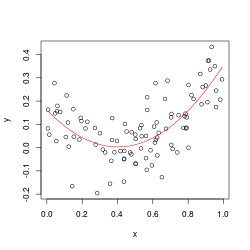

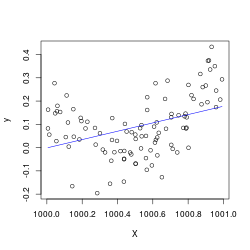

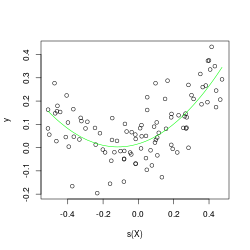

In [4]:
%%R -i x -i n -w 5 -h 5 --units in -r 50

set.seed(1)
y <- .2*(x-.5)+(x-.5)^2 + rnorm(n)*.1
A <- lm(y ~ x+I(x^2))

# regression works fine
plot(x,y); lines(x, predict(A), col='red')


X <- x + 1000
B <- lm(y ~ X+I(X^2))

# regression breaks
plot(X,y); lines(X, predict(B), col='blue')

s <- function(x) scale(x, center=TRUE, scale=FALSE)
C <- lm(y ~ s(X)+I(s(X^2)))

# regression saved
plot(s(X),y); lines(s(X), predict(C), col='green')

In [5]:
X = x + 1000
XX = np.column_stack([X, X ** 2])
np.linalg.cond(add1(XX))

13136545821949.57

In [6]:
np.linalg.cond(add1(XX - XX.mean(axis=0)))

14525417.086313704

The condition numbers above don't lie re: centering's contractive properties.

What's more is that even though scaling will not help conditioning, it can help with stability of the standard errors. Recall for the $i$-th coefficient the standard error is $\hat\sigma v_i(X)^{1/2}=\hat\sigma\sqrt{(X_+^\top X_+)^{-1}_{ii}}$ where $X_+=\begin{pmatrix}\mathbf{1} & X\end{pmatrix}$ is the intercept-extended design and $n\hat\sigma^2$ is the residual sum of squares from the regression.

Belsley et al (from Regression Diagnostics) show this through elasticity (as opposed to traditional perturbation analysis).
Consider the sensitivity of each variance estimator by viewing $v_i(X)$ as a function of the design.

The elasticity $\xi_{jk}^{(i)}(X)=\frac{\partial_{x_{jk}}v_i(X)}{v_i(X)/x_{jk}}$, which measures the instantaneous ratio of relative change in the output to the input $jk$-th entry of $X$, can be shown via matrix derivatives to be invariant to scaling. Coupled with another inequality, this shows that $|\xi_{jk}|\le 2 \kappa(XG)$ for any diagonal matrix $G$, so we may as well choose one that minimizes $\kappa(XG)$. This again plays no role on the actual $\boldsymbol\beta$ solution stiffness.

Finding a minimal $G$ for this is hard, but unit normalization (scaling each column by its $\ell_2$ norm) can be shown to be $\sqrt{p}$-optimal. This is remniscent of the Jacobi (diagonal) preconditioner for solving linear systems of $X^\top X$ (see [this preconditioning reading](http://people.maths.ox.ac.uk/wathen/preconditioning.pdf)). Altogether, this seems important if you want to control elasticities, I guess. Both of the norms below are wildly large.

In [7]:
# create a tall random matrix A st A'A is rank n-1
n = 5
np.random.seed(1234)
A = np.random.randn(n, n)
Q, R = sla.qr(A)
for i in range(n):
    R[i, i] = max(R[i, i], 1e-3)
R[-1, -1] = 0
A = Q.dot(R)

A = np.tile(A, (3, 1))

def perturb(X, eps=1e-5, d=None):
    nsamples = 200
    change = 0
    iX = np.sqrt(invdiag(X))
    for _ in range(nsamples):
        XX = X.copy()
        if d is None:
            r = np.random.randn(X.shape[0])
        else:
            r = d.copy()
        r /= sla.norm(r)
        r *= eps
        XX[:, np.random.choice(X.shape[1])] += r
        change += sla.norm(iX - invdiag(XX))
    return change / sla.norm(iX) / eps / nsamples

pA = perturb(A)
pB = perturb(A / sla.norm(A, axis=0))
np.log(pA), np.log(pB)

(45.13480361714671, 36.12565934643282)

# Other discussion

Centering can destroy sparsity if you're not careful (though there are ways around this).

Other good resources from SO include [this question](https://stats.stackexchange.com/questions/29781) and some related [links](http://www.faqs.org/faqs/ai-faq/neural-nets/part2/section-16.html), with more discussion on [interaction terms and centering](https://stats.stackexchange.com/questions/60476/collinearity-diagnostics-problematic-only-when-the-interaction-term-is-included/61022#61022) and other [SO](https://stats.stackexchange.com/questions/19216/variables-are-often-adjusted-e-g-standardised-before-making-a-model-when-is) [links](https://stats.stackexchange.com/questions/7112/when-and-how-to-use-standardized-explanatory-variables-in-linear-regression).

# Row Deletion

Outliers, in the sense of high-leverage points, can both hide and create degeneracy.

In cases of hiding degeneracy, this can result in poor fits with a sense of false security. Removing the outlier which obscures degeneracy means we can fit a more appropriate regression by dropping one of the columns (next section).

Similarly, outliers can create degeneracy as well. In this case they should simply be removed. Both examples are from Linear Regression Analysis 10.7.3.

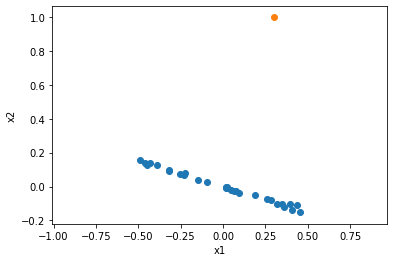

(1.6362290065258522, 38.5385073413727)

In [8]:
n = 30
x1 = np.random.uniform(size=n)
slope = -.3
x2 = x1 * slope
x2 += np.random.randn(len(x2)) * np.std(x2) / 10
x1 -= x1.mean()
x2 -= x2.mean()

from scipy.spatial.transform import Rotation as R
r = R.from_rotvec(np.pi/2 * np.array([0, 0, 1]))
ox1, ox2, _ = r.apply((1, slope, 0))

from matplotlib import pyplot as plt
plt.scatter(x1, x2)
plt.scatter(ox1, ox2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.gca().axis('equal')
plt.show()

X = np.block([[x1, ox1], [x2, ox2]]).T
np.linalg.cond(X), np.linalg.cond(X[:-1])

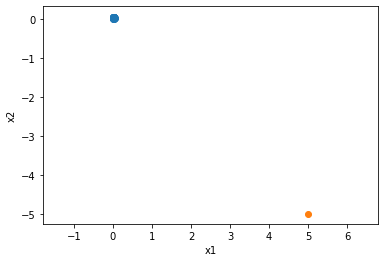

(40.592976716052036, 2.3683688696481386)

In [9]:
n = 30
x1, x2 = np.random.uniform(size=(2, n)) * .05

ox1, ox2 = (5, -5)

from matplotlib import pyplot as plt
plt.scatter(x1, x2)
plt.scatter(ox1, ox2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.gca().axis('equal')
plt.show()

X = np.block([[x1, ox1], [x2, ox2]]).T
np.linalg.cond(X), np.linalg.cond(X[:-1])

# Column Deletion

As is clear, dropping columns removes degeneracy (since you only have linearly independent columns left).

The choice is best made by pivoting procedures, such as the QR procedure used in `invdiag`. In some cases (such as incremental regressions), this requires some care. If you only have the Gram matrix available, pivoting Cholesky works (but you are dealing with a larger condition number).

# Ridge Regression

The ridge adds $\lambda\|\boldsymbol\beta\|_2^2$ regularization which results in a different optimum, $\boldsymbol\beta_\lambda=(X^\top X + \lambda I)^{-1}X^\top\mathbf{y}$, which is clearly biased. It can be connected to a Bayesian setting with a normal prior $N(0, \sigma^2\lambda I)$ for $\boldsymbol\beta$.

Thus it is best analyzed through the lens of MSE, which captures both bias and variance in the ridge-regressed estimate. Unfortunately for selecting $\lambda$ by optimizing MSE, we require knowing $\sigma^2,\boldsymbol\beta$, which we don't know the true values of. Replacing them with estimators unfortunately does not guarantee improvement over least squares.

Various replacements for what is being estimated in the (unknown) MSE equation to select $\lambda$ result in different proposal estimators SRIDG, RIDGM. Cross validation is popular today, but typically seems to underestimate $\lambda$ for inference purposes. E.g., see the [1se](https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html) option for lasso CV.